# Natural Language Processing w/ Disaster Tweets

# Step One: Project Overview

The goal of this project is to build a model that can predict if a tweet is about a real disaster or not. This kind of model could be useful for groups that want to monitor tweets for emergencies in real time. We are given access to 10,000 tweets that can be used to train and validate the model that's built.

Competition link: https://www.kaggle.com/competitions/nlp-getting-started/overview

# Step Two: Exploratory Data Analysis

In this section, I'll be exploring the training data we have available. I will also be pre-processing some of the text data to get it ready to be input into the model. 

 ## Loading Data From Kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Save data to usable dataframes
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

## Exploring the Data

In [3]:
# Lets look at dimensions: 
print(f"Training data: {train.shape[0]} entries, {train.shape[1]} attributes")
print(f"Validation data: {test.shape[0]} entries, {test.shape[1]} attributes")

# Attributes
print(f"Available attributes: {list(train.columns)}")

Training data: 7613 entries, 5 attributes
Validation data: 3263 entries, 4 attributes
Available attributes: ['id', 'keyword', 'location', 'text', 'target']


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
import matplotlib.pyplot as plt
def column_values(df: pd.DataFrame, column: str, plot: bool = False) -> None:
    unique_values = df[column].unique()
    nan_count = df[column].isna().sum()
    print(f"{column} | Found {len(unique_values)} unique values and {nan_count} NaN values")
    
    if plot: 
        value_counts = df[column].value_counts()
        top_values  = value_counts.head(50)
        plt.figure(figsize=(12, 3))
        plt.bar(top_values.index.astype(str), top_values.values)
        plt.xlabel('Unique Values')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.title(f'Value Counts for Column "{column}"')
        plt.show()

keyword | Found 222 unique values and 61 NaN values


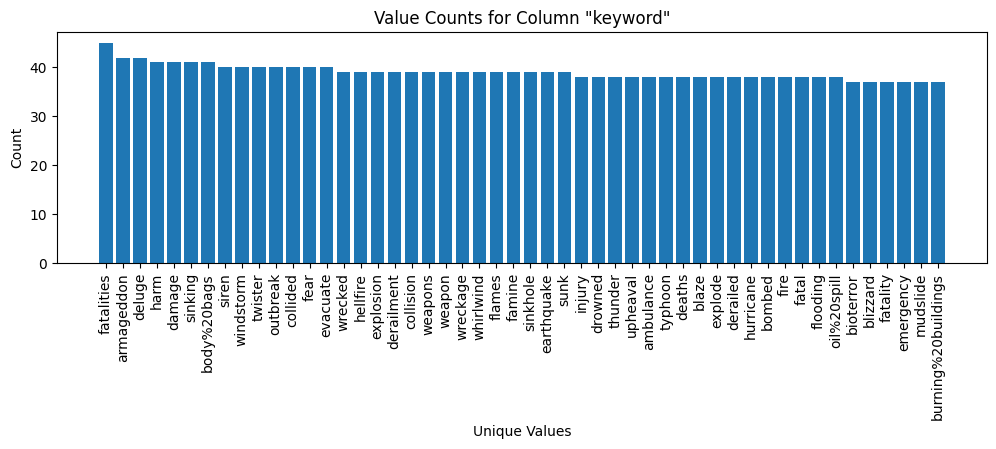

In [6]:
column_values(train, 'keyword', plot=True)

location | Found 3342 unique values and 2533 NaN values


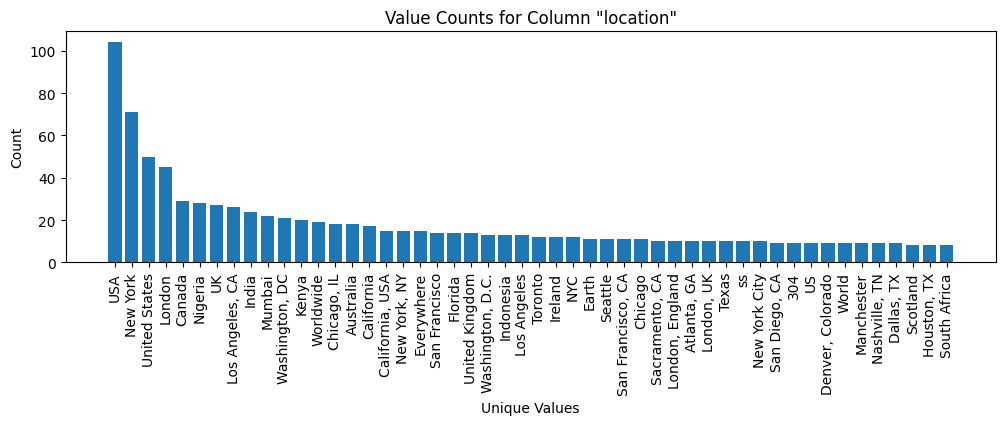

In [7]:
column_values(train, 'location', plot=True)

target | Found 2 unique values and 0 NaN values


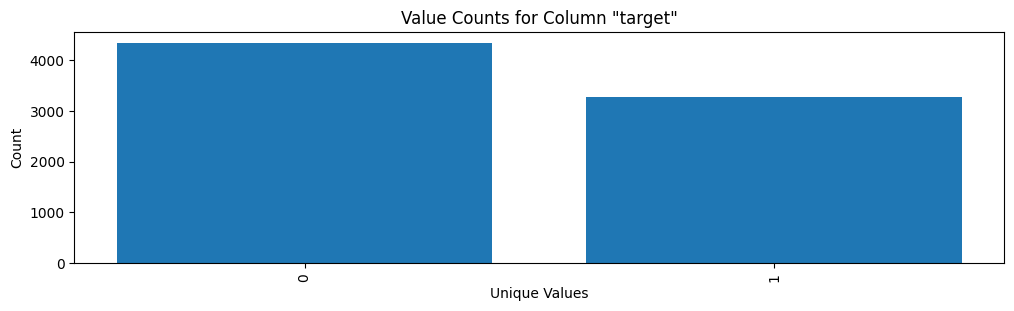

In [8]:
column_values(train, 'target', plot=True)

## Exploring the Tweets

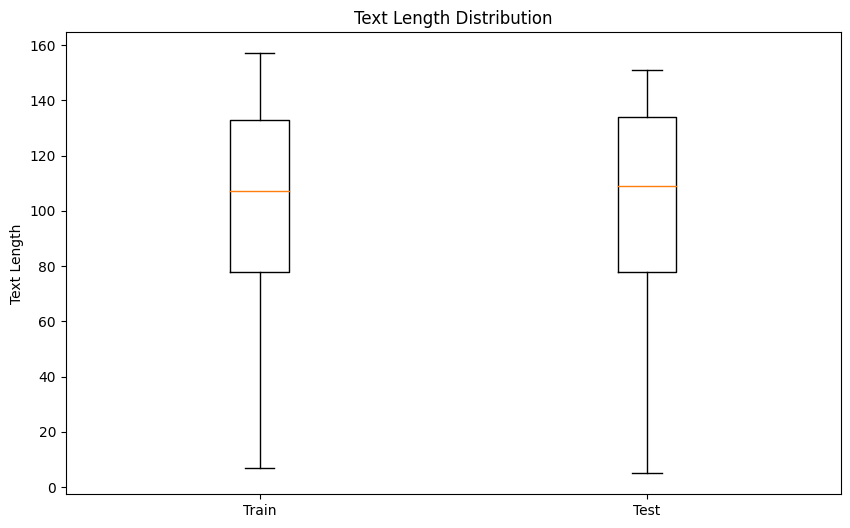

In [9]:
train["text_length"] = train["text"].apply(lambda x : len(x))
test["text_length"] = test["text"].apply(lambda x : len(x))

plt.figure(figsize=(10, 6))
plt.boxplot([train["text_length"], test["text_length"]], labels=['Train', 'Test'])
plt.title('Text Length Distribution')
plt.ylabel('Text Length')
plt.show()


In [10]:
import pandas as pd

# Calculate average word count
train['word_count'] = train['text'].apply(lambda x: len(x.split()))
average_word_count = train['word_count'].mean()

# Calculate average word length
train['word_length'] = train['text'].apply(lambda x: len(x.replace(' ', '')) / len(x.split()))
average_word_length = train['word_length'].mean()

print("Average Word Count:", average_word_count)
print("Average Word Length:", average_word_length)


Average Word Count: 14.903585971364771
Average Word Length: 6.136451041590252


In [11]:
# Let's see what a few tweets look like 
disaster = train[train['target'] == 1]
not_disaster = train[train['target'] == 0]

In [12]:
# Disaster tweets
for i in range(5): 
    print(disaster['text'].iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [13]:
# Not disaster tweets
for i in range(5): 
    print(not_disaster['text'].iloc[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


The tweets above have a lot of punctuation and different cases, it may be useful to strip those as a part of the pre-processing.

In [14]:
import re
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Preprocess the text data
train['text'] = train['text'].apply(preprocess_text)

# Step Three: Model Architecture
This model uses LSTM (Long Short-Term Memory) layers to understand and classify text data. It starts by converting words into numerical vectors using an Embedding layer. Then, three LSTM layers process the sequences, each followed by a Dropout layer to try to prevent overfitting.

It's trained using the Adam optimizer and binary cross-entropy loss. I've set the model to run a maximum of 10 epochs, but early stopping is implemented to make sure we stop training when validation is no longer showing signs of improvement - this'll help prevent overfitting and keep us from wasting time.

The model is also designed to be configurable, so when we get to model tuning we can tune the following parameters to see which perform best: 'activation','l2_penalty','learning_rate','batch_size', 'dropout'.

In [15]:
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import warnings

def build_model(activation: str, l2_penalty: float, learning_rate: float, batch_size: int, dropout:bool):
    # Tokenize the text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train['text'])
    X = tokenizer.texts_to_sequences(train['text'])
    X = pad_sequences(X)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, train['target'], test_size=0.1, random_state=42)

    # Build the model
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=X.shape[1]))
    regularizer = None
    if l2_penalty:
        regularizer = regularizers.l2(l2_penalty)

    model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizer))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizer))
    if dropout:
        model.add(Dropout(0.5))
    model.add(LSTM(32, kernel_regularizer=regularizer))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(1, activation=activation))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    
    # Train the model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Loss: {loss}, Accuracy: {accuracy}')
    return (model, accuracy, history)

2024-02-23 22:16:40.557433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 22:16:40.557525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 22:16:40.702954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def predict(model, df):
    # Tokenize the text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train['text'])
    X = tokenizer.texts_to_sequences(train['text'])
    X = pad_sequences(X)

    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(classification_report(train['target'], y_pred_binary))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(train['target'], y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
# Prep DataFrame to Store results
model_inputs = ['activation','l2_penalty','learning_rate','batch_size', 'dropout']
results = pd.DataFrame(columns=model_inputs+['accuracy'])
models = []
histories = []

def test_model(model_args) -> None:
    (model, accuracy, history) = build_model(**model_args)
    results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}
    models.append(model)
    histories.append(history)

## Base Model

In the base run of the model we'll run with some standard parameters just to get an idea of how we perform using defaults.

In [19]:
base_model_args = {
    'activation':'sigmoid',
    'l2_penalty': 0.2, 
    'learning_rate':0.001,
    'batch_size':32,
    'dropout': False
}
test_model(base_model_args)

Epoch 1/10


I0000 00:00:1708726621.217103      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 16s 47ms/step - loss: 15.8258 - accuracy: 0.5716 - val_loss: 0.8421 - val_accuracy: 0.5591
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7074 - accuracy: 0.5716 - val_loss: 0.6868 - val_accuracy: 0.5591
Epoch 3/10
215/215 [==============================] - 3s 13ms/step - loss: 0.6833 - accuracy: 0.5716 - val_loss: 0.6869 - val_accuracy: 0.5591
Epoch 4/10
215/215 [==============================] - 3s 13ms/step - loss: 0.6833 - accuracy: 0.5716 - val_loss: 0.6870 - val_accuracy: 0.5591
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5591
Loss: 0.6867941617965698, Accuracy: 0.5590550899505615


In [20]:
results.head()

,activation,l2_penalty,learning_rate,batch_size,dropout,accuracy
0,sigmoid,0.2,0.001,32,False,0.559055


# Step Four: Results and Analysis 

## Model Tuning

The base model didn't have great accuracy. So below we are going to tune some of the parameters to see which may boost our accuracy: 'l2_penalty', 'learning_rate', 'batch_size', and 'dropout'. 

In [21]:
import itertools
model_args = {
    'activation':['sigmoid'],
    'l2_penalty': [None, 0.2] ,
    'learning_rate': [0.0005, 0.001],
    'batch_size': [32, 64],
    'dropout': [False, True]
}
# Create permutations of all model args above to see which produce the best result
all_args = [dict(zip(model_args.keys(), values)) for values in itertools.product(*model_args.values())]
n = len(all_args)

for i, args in enumerate(all_args):
    print(f"Model Iteration: {i+1}/{n}")
    print(args)
    test_model(args)
    print()

Model Iteration: 1/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': False}
Epoch 1/10
215/215 [==============================] - 15s 46ms/step - loss: 0.5422 - accuracy: 0.7176 - val_loss: 0.4707 - val_accuracy: 0.7887
Epoch 2/10
215/215 [==============================] - 4s 18ms/step - loss: 0.3098 - accuracy: 0.8790 - val_loss: 0.5219 - val_accuracy: 0.7493
Epoch 3/10
215/215 [==============================] - 3s 14ms/step - loss: 0.1729 - accuracy: 0.9396 - val_loss: 0.6048 - val_accuracy: 0.7612
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4707 - accuracy: 0.7887
Loss: 0.4706735610961914, Accuracy: 0.7887139320373535

Model Iteration: 2/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': True}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
215/215 [==============================] - 16s 50ms/step - loss: 0.5864 - accuracy: 0.6913 - val_loss: 0.4763 - val_accuracy: 0.7795
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.3495 - accuracy: 0.8631 - val_loss: 0.4839 - val_accuracy: 0.7927
Epoch 3/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2096 - accuracy: 0.9292 - val_loss: 0.5955 - val_accuracy: 0.7690
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4763 - accuracy: 0.7795
Loss: 0.47625118494033813, Accuracy: 0.7795275449752808

Model Iteration: 3/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': False}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
108/108 [==============================] - 13s 75ms/step - loss: 0.5899 - accuracy: 0.6798 - val_loss: 0.4811 - val_accuracy: 0.7848
Epoch 2/10
108/108 [==============================] - 4s 37ms/step - loss: 0.3380 - accuracy: 0.8608 - val_loss: 0.4869 - val_accuracy: 0.7808
Epoch 3/10
108/108 [==============================] - 3s 25ms/step - loss: 0.1933 - accuracy: 0.9291 - val_loss: 0.6012 - val_accuracy: 0.7756
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4811 - accuracy: 0.7848
Loss: 0.48106837272644043, Accuracy: 0.7847769260406494

Model Iteration: 4/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': True}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
108/108 [==============================] - 13s 79ms/step - loss: 0.6200 - accuracy: 0.6491 - val_loss: 0.4887 - val_accuracy: 0.7808
Epoch 2/10
108/108 [==============================] - 4s 34ms/step - loss: 0.3650 - accuracy: 0.8539 - val_loss: 0.4613 - val_accuracy: 0.7992
Epoch 3/10
108/108 [==============================] - 2s 22ms/step - loss: 0.2316 - accuracy: 0.9178 - val_loss: 0.6086 - val_accuracy: 0.7533
Epoch 4/10
108/108 [==============================] - 2s 15ms/step - loss: 0.1483 - accuracy: 0.9521 - val_loss: 0.6925 - val_accuracy: 0.7822
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 0.4613 - accuracy: 0.7992
Loss: 0.46130090951919556, Accuracy: 0.7992125749588013

Model Iteration: 5/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': False}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
215/215 [==============================] - 15s 47ms/step - loss: 0.5147 - accuracy: 0.7489 - val_loss: 0.4810 - val_accuracy: 0.8031
Epoch 2/10
215/215 [==============================] - 3s 15ms/step - loss: 0.2642 - accuracy: 0.8975 - val_loss: 0.5346 - val_accuracy: 0.7638
Epoch 3/10
215/215 [==============================] - 3s 14ms/step - loss: 0.1172 - accuracy: 0.9588 - val_loss: 0.6761 - val_accuracy: 0.7559
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 0.4810 - accuracy: 0.8031
Loss: 0.4809980094432831, Accuracy: 0.8031495809555054

Model Iteration: 6/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': True}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
215/215 [==============================] - 15s 49ms/step - loss: 0.5308 - accuracy: 0.7399 - val_loss: 0.4694 - val_accuracy: 0.7940
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.2992 - accuracy: 0.8818 - val_loss: 0.5090 - val_accuracy: 0.7730
Epoch 3/10
215/215 [==============================] - 3s 15ms/step - loss: 0.1537 - accuracy: 0.9482 - val_loss: 0.6513 - val_accuracy: 0.7520
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4694 - accuracy: 0.7940
Loss: 0.46938398480415344, Accuracy: 0.7939632534980774

Model Iteration: 7/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': False}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
108/108 [==============================] - 13s 81ms/step - loss: 0.5474 - accuracy: 0.7190 - val_loss: 0.4780 - val_accuracy: 0.7717
Epoch 2/10
108/108 [==============================] - 3s 30ms/step - loss: 0.2908 - accuracy: 0.8841 - val_loss: 0.5218 - val_accuracy: 0.7638
Epoch 3/10
108/108 [==============================] - 2s 19ms/step - loss: 0.1500 - accuracy: 0.9486 - val_loss: 0.6536 - val_accuracy: 0.7572
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 0.4780 - accuracy: 0.7717
Loss: 0.4780210554599762, Accuracy: 0.7716535329818726

Model Iteration: 8/16
{'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': True}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
108/108 [==============================] - 14s 80ms/step - loss: 0.5633 - accuracy: 0.7040 - val_loss: 0.4775 - val_accuracy: 0.7874
Epoch 2/10
108/108 [==============================] - 4s 39ms/step - loss: 0.3164 - accuracy: 0.8791 - val_loss: 0.5386 - val_accuracy: 0.7782
Epoch 3/10
108/108 [==============================] - 2s 17ms/step - loss: 0.1694 - accuracy: 0.9388 - val_loss: 0.6667 - val_accuracy: 0.7454
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4775 - accuracy: 0.7874
Loss: 0.4775073826313019, Accuracy: 0.787401556968689

Model Iteration: 9/16
{'activation': 'sigmoid', 'l2_penalty': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': False}


/tmp/ipykernel_27/3184265764.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}


Epoch 1/10
215/215 [==============================] - 15s 49ms/step - loss: 30.4465 - accuracy: 0.5713 - val_loss: 5.0598 - val_accuracy: 0.5591
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 2.0466 - accuracy: 0.5716 - val_loss: 0.8865 - val_accuracy: 0.5591
Epoch 3/10
215/215 [==============================] - 3s 14ms/step - loss: 0.7441 - accuracy: 0.5716 - val_loss: 0.6937 - val_accuracy: 0.5591
Epoch 4/10
215/215 [==============================] - 2s 11ms/step - loss: 0.6852 - accuracy: 0.5716 - val_loss: 0.6868 - val_accuracy: 0.5591
Epoch 5/10
215/215 [==============================] - 3s 13ms/step - loss: 0.6833 - accuracy: 0.5716 - val_loss: 0.6865 - val_accuracy: 0.5591
Epoch 6/10
215/215 [==============================] - 3s 12ms/step - loss: 0.6833 - accuracy: 0.5716 - val_loss: 0.6862 - val_accuracy: 0.5591
Epoch 7/10
215/215 [==============================] - 2s 10ms/step - loss: 0.6834 - accuracy: 0.5716 - val_loss: 0.6863 - val_accuracy: 0.55

The table below will show us which set of parameters performed best:

In [22]:
results.sort_values(by='accuracy', ascending=False)

,activation,l2_penalty,learning_rate,batch_size,dropout,accuracy
5,sigmoid,NaN,0.0010,32,False,0.803150
4,sigmoid,NaN,0.0005,64,True,0.799213
6,sigmoid,NaN,0.0010,32,True,0.793963
1,sigmoid,NaN,0.0005,32,False,0.788714
8,sigmoid,NaN,0.0010,64,True,0.787402
3,sigmoid,NaN,0.0005,64,False,0.784777
2,sigmoid,NaN,0.0005,32,True,0.779528
7,sigmoid,NaN,0.0010,64,False,0.771654
11,sigmoid,0.2,0.0005,64,False,0.748031
15,sigmoid,0.2,0.0010,64,False,0.736220


In [23]:
max_accuracy_row = results.loc[results['accuracy'].idxmax()].to_dict()
max_accuracy_row.pop('accuracy')
max_accuracy_row = {k: v if not pd.isna(v) else None for k, v in max_accuracy_row.items()}

print(f"Best Args: {max_accuracy_row}")

Best Args: {'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': False}


Before we move on - lets take a look at the breakdown of how the parameters perform on average:

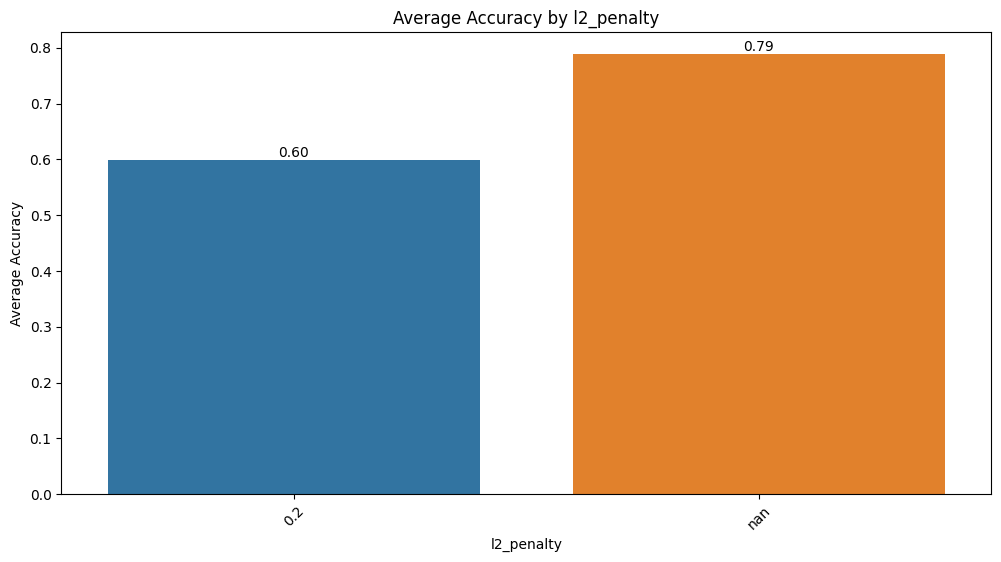

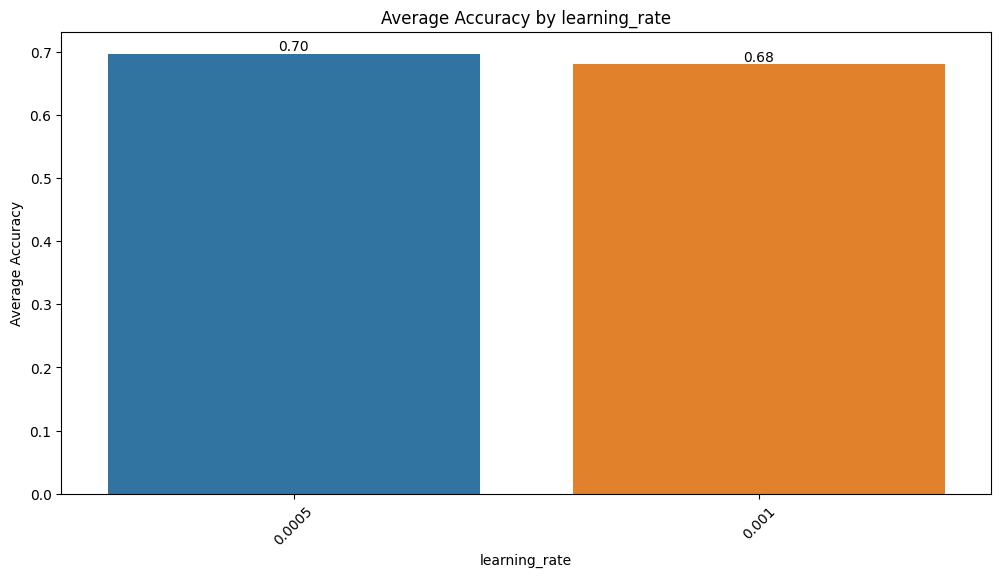

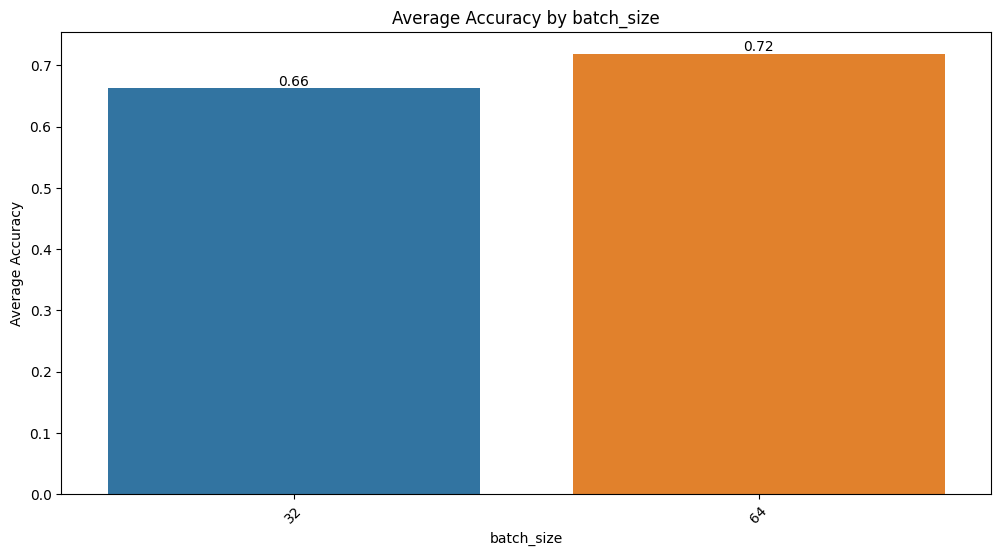

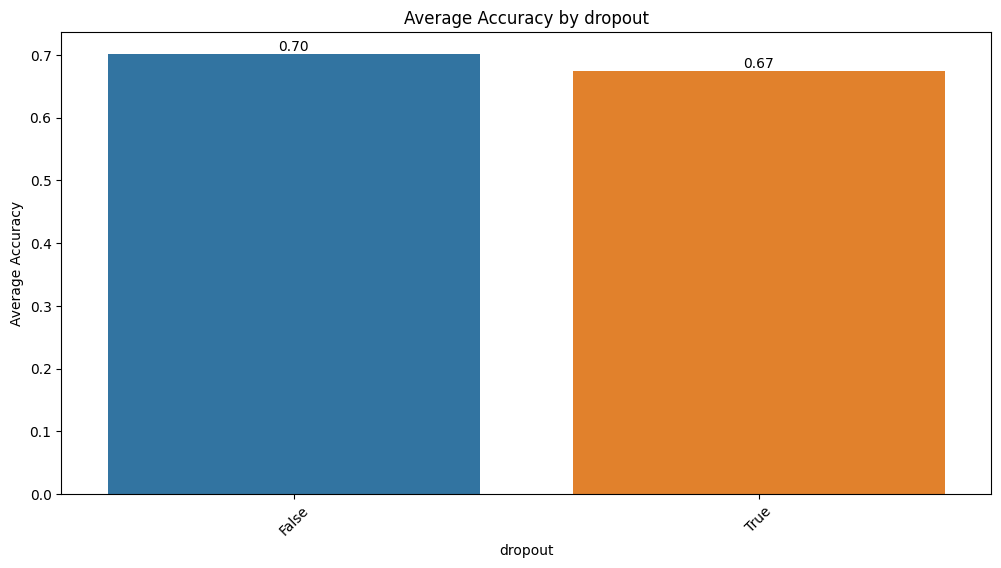

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['l2_penalty', 'learning_rate', 'batch_size', 'dropout']

for column in columns:
    plt.figure(figsize=(12, 6))
    avg_accuracy = results.groupby(column, dropna=False)['accuracy'].mean().reset_index()
    avg_accuracy[column] = avg_accuracy[column].astype(str)  # Convert column to strin
    sns.barplot(x=column, y='accuracy', data=avg_accuracy)
    plt.title(f'Average Accuracy by {column}')
    plt.xlabel(column)
    plt.ylabel('Average Accuracy')
    plt.xticks(rotation=45)
    for i, row in avg_accuracy.iterrows():
        plt.text(i, row['accuracy'], f'{row["accuracy"]:.2f}', ha='center', va='bottom')
    
    plt.show()


From the above we can see the following are usually producing best results:

- Learning Rate: 0.0005
- Batch Size: 64
- Dropout: False
- L2 Penalty: None

However we see that the model with those parameters doesn't have the best overall accuracy, but it is still pretty high.


In [25]:
# Assuming 'results' is your DataFrame
best_params = {}
columns = ['activation', 'l2_penalty', 'learning_rate', 'batch_size', 'dropout']

for column in columns:
    best_value = results.groupby(column)['accuracy'].mean().idxmax()
    best_params[column] = best_value

print(best_params)
best_param_result = results.loc[
    (results['learning_rate'] == best_params['learning_rate']) & 
    (results['batch_size'] == best_params['batch_size']) & 
    (results['l2_penalty'] == best_params['l2_penalty']) & 
    (results['dropout'] == best_params['dropout'])]
print()

{'activation': 'sigmoid', 'l2_penalty': 0.2, 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': False}



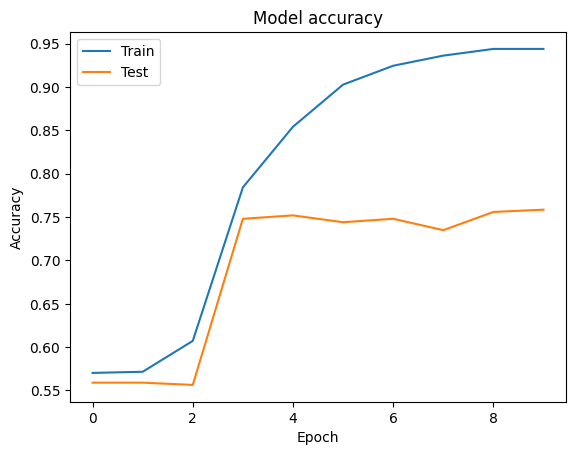

In [26]:
plot_history(histories[best_param_result.index[0]])

238/238 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4342
           1       0.96      0.86      0.90      3271

    accuracy                           0.92      7613
   macro avg       0.93      0.91      0.92      7613
weighted avg       0.92      0.92      0.92      7613

Confusion Matrix:


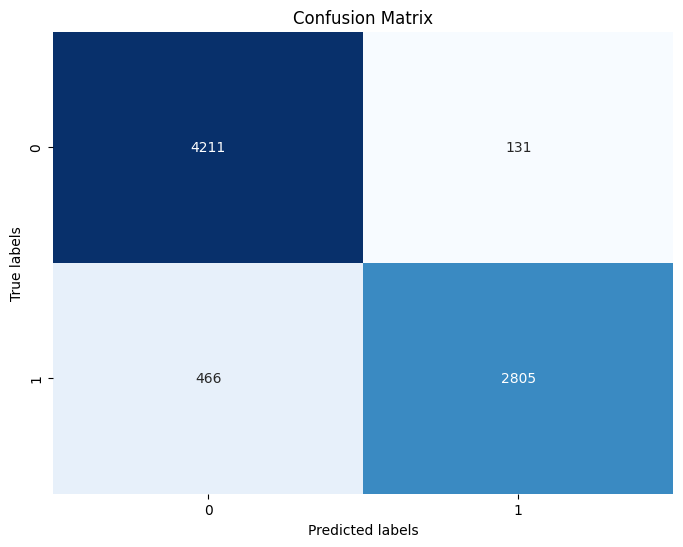

In [27]:
predict(models[best_param_result.index[0]], train)

## Final Model

The final model details can be found here. We are using this one because it performed the best during training.

In [28]:
max_accuracy_idx = results['accuracy'].idxmax()
max_accuracy_row = results.loc[max_accuracy_idx].to_dict()
max_accuracy_row.pop('accuracy')
max_accuracy_row = {k: v if not pd.isna(v) else None for k, v in max_accuracy_row.items()}
print(f"Best Args: {max_accuracy_row}")

Best Args: {'activation': 'sigmoid', 'l2_penalty': None, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': False}


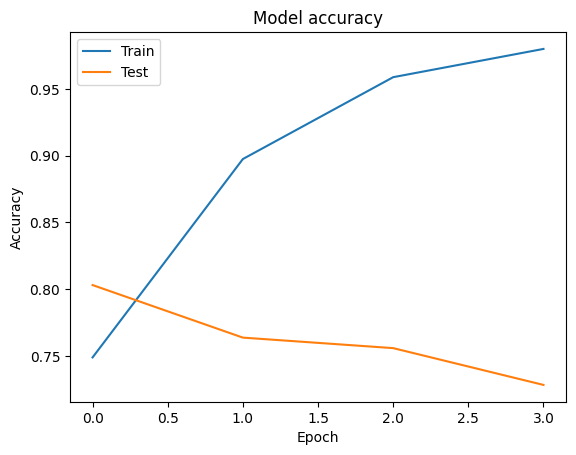

In [29]:
plot_history(histories[max_accuracy_idx])

238/238 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4342
           1       0.95      0.76      0.84      3271

    accuracy                           0.88      7613
   macro avg       0.90      0.86      0.87      7613
weighted avg       0.89      0.88      0.88      7613

Confusion Matrix:


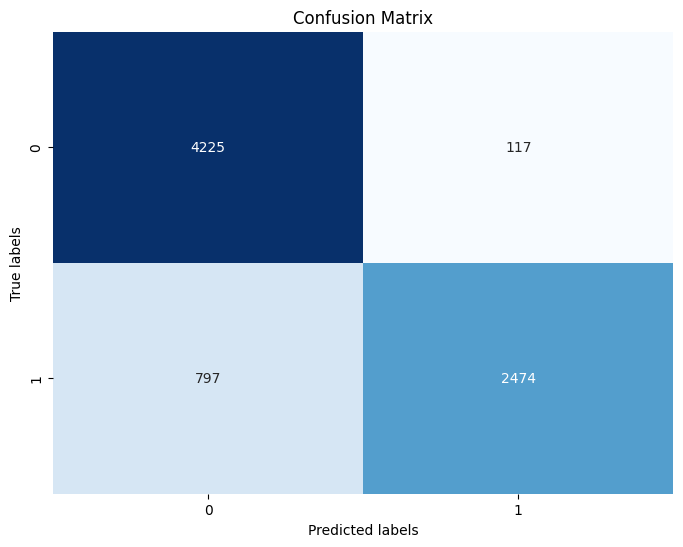

In [30]:
predict(models[max_accuracy_idx], train)

# Step Five: Conclusion + Future Steps

From the above we can see the following are usually producing best results:
- Learning Rate: 0.0005
- Batch Size: 64
- Dropout: False
- L2 Penalty: None

In all, the model accuracy in the notebook ended up in the high 70s, which is an improvement from the initial model which had an accuracy in the 50s. It's still not quite as high as we'd like to see, in the future, some possible steps to improve would be to try more iterations of learning rate, adjust regularization approach and also make the dropout rate configurable as well. 

## Generate Competition Submission 

In [31]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

chosen_model = models[max_accuracy_idx]

def make_submission(model, df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['text'])
    X = tokenizer.texts_to_sequences(df['text'])
    X = pad_sequences(X)

    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    results_df = pd.DataFrame({'id': df['id'], 'target': y_pred_binary.reshape(-1)})
    filename = "submission.csv"
    results_df.to_csv(filename, index=False)
    print(f"Generated submission: {filename}")

make_submission(chosen_model, test)

102/102 [==============================] - 0s 4ms/step
Generated submission: submission.csv
